In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from upsetplot import from_indicators
from upsetplot import UpSet

def format_type(s):
    words = s.split()
    return words[0].capitalize() + " " + " ".join(w.lower() for w in words[1:])
    

In [2]:
genes = pd.read_pickle('./OT/Final/protein_coding_genes.pkl')
genes = genes.loc[~genes['gene'].str.contains('ENSG')]
tg = pd.read_pickle('./Drugs/targets.pkl')
tg = tg.loc[tg['gene'].isin(genes['gene'])]

out = tg[['id','type','phase','gene','moa','action','sources']]
out['type'] = out['type'].apply(format_type).str.strip()
out['action'] = out['action'].astype(str).apply(format_type).str.strip()
out = out.set_axis(['Internal drug ID','Drug type','Phase','Gene','DOE','Mechanism','Supporting sources'],axis=1)
out.to_csv('./Public/Datasets/drug_mechanisms.csv', index=False)


In [127]:
tg = pd.read_csv('./Public/Datasets/drug_mechanisms.csv').rename({'Internal drug ID':'ID'},axis=1)
print('Unique drugs: ',tg['ID'].nunique())
print(tg.drop_duplicates(['ID','Phase'])['Phase'].value_counts())


Unique drugs:  7341
Phase
 4.0    3381
-1.0    1827
 2.0    1212
 3.0     607
 1.0     314
Name: count, dtype: int64


In [130]:
dt = tg[['ID','Drug type']].drop_duplicates('ID')['Drug type'].value_counts().reset_index()
dt['prop'] = dt['count']/7341
dt['Drug type'] = dt['Drug type'].apply(format_type).str.strip()
dt


,Drug type,count,prop
0,Small molecule,5777,0.786950
1,Antibody,593,0.080779
2,Protein,304,0.041411
3,Unspecified biologic,282,0.038414
4,Unknown,221,0.030105
5,Antibody drug conjugate,71,0.009672
6,Peptide,45,0.006130
7,Gene,15,0.002043
8,Oligonucleotide,15,0.002043
9,Oligosaccharide,14,0.001907


Text(0, 0.5, '')

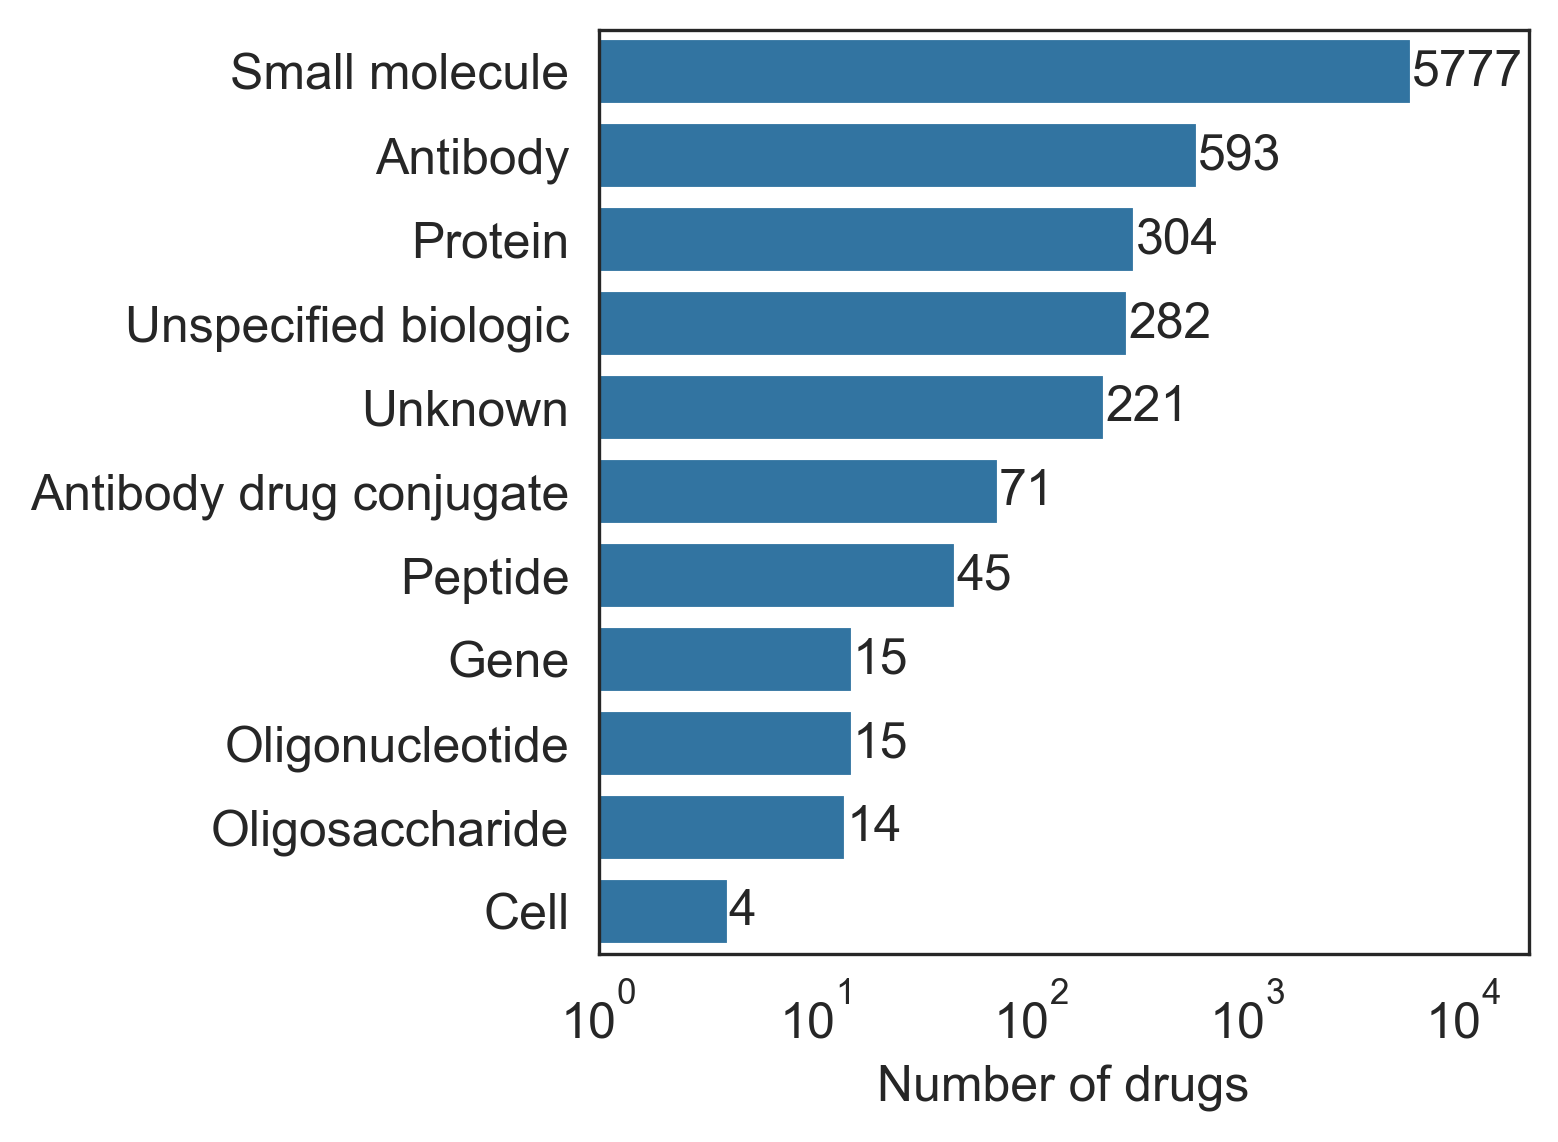

In [132]:
sns.set_style('white')
plt.figure(figsize=(4,4), dpi=300)

ax = sns.barplot(dt, x='count', y='Drug type')
ax.bar_label(ax.containers[0])
plt.xlim([1,20000])
plt.xscale('log')
plt.xlabel('Number of drugs')
plt.ylabel('')


Text(0, 0.5, '')

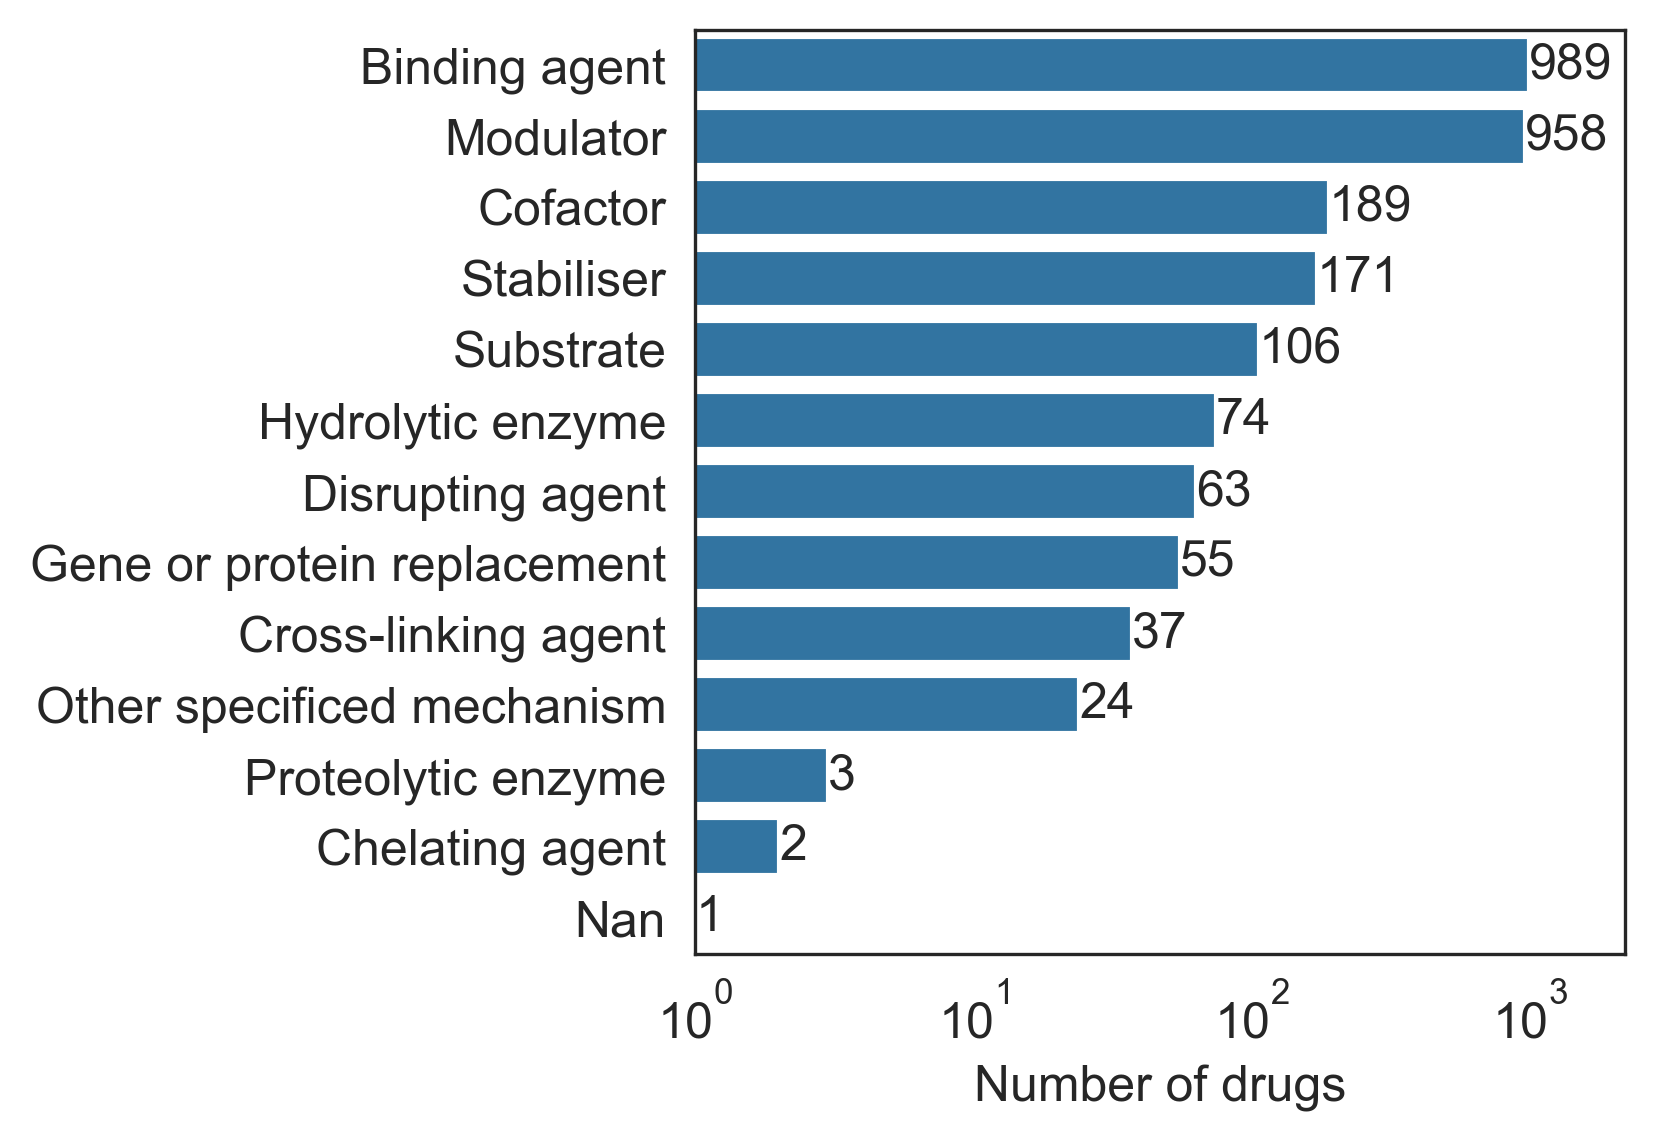

In [135]:
ot = tg.loc[tg['DOE'] == 'Other']['Mechanism'].value_counts().reset_index()
ot['Mechanism'] = ot['Mechanism'].apply(format_type).str.strip()
ot.loc[ot['Mechanism'] == 'Other specified', 'Mechanism'] = 'Other specificed mechanism'

sns.set_style('white')
plt.figure(figsize=(4,4), dpi=300)

ax = sns.barplot(ot, x='count', y='Mechanism')
ax.bar_label(ax.containers[0])
plt.xlim([1,2200])
plt.xscale('log')
plt.xlabel('Number of drugs')
plt.ylabel('')


1.0 2.0
4075
6487


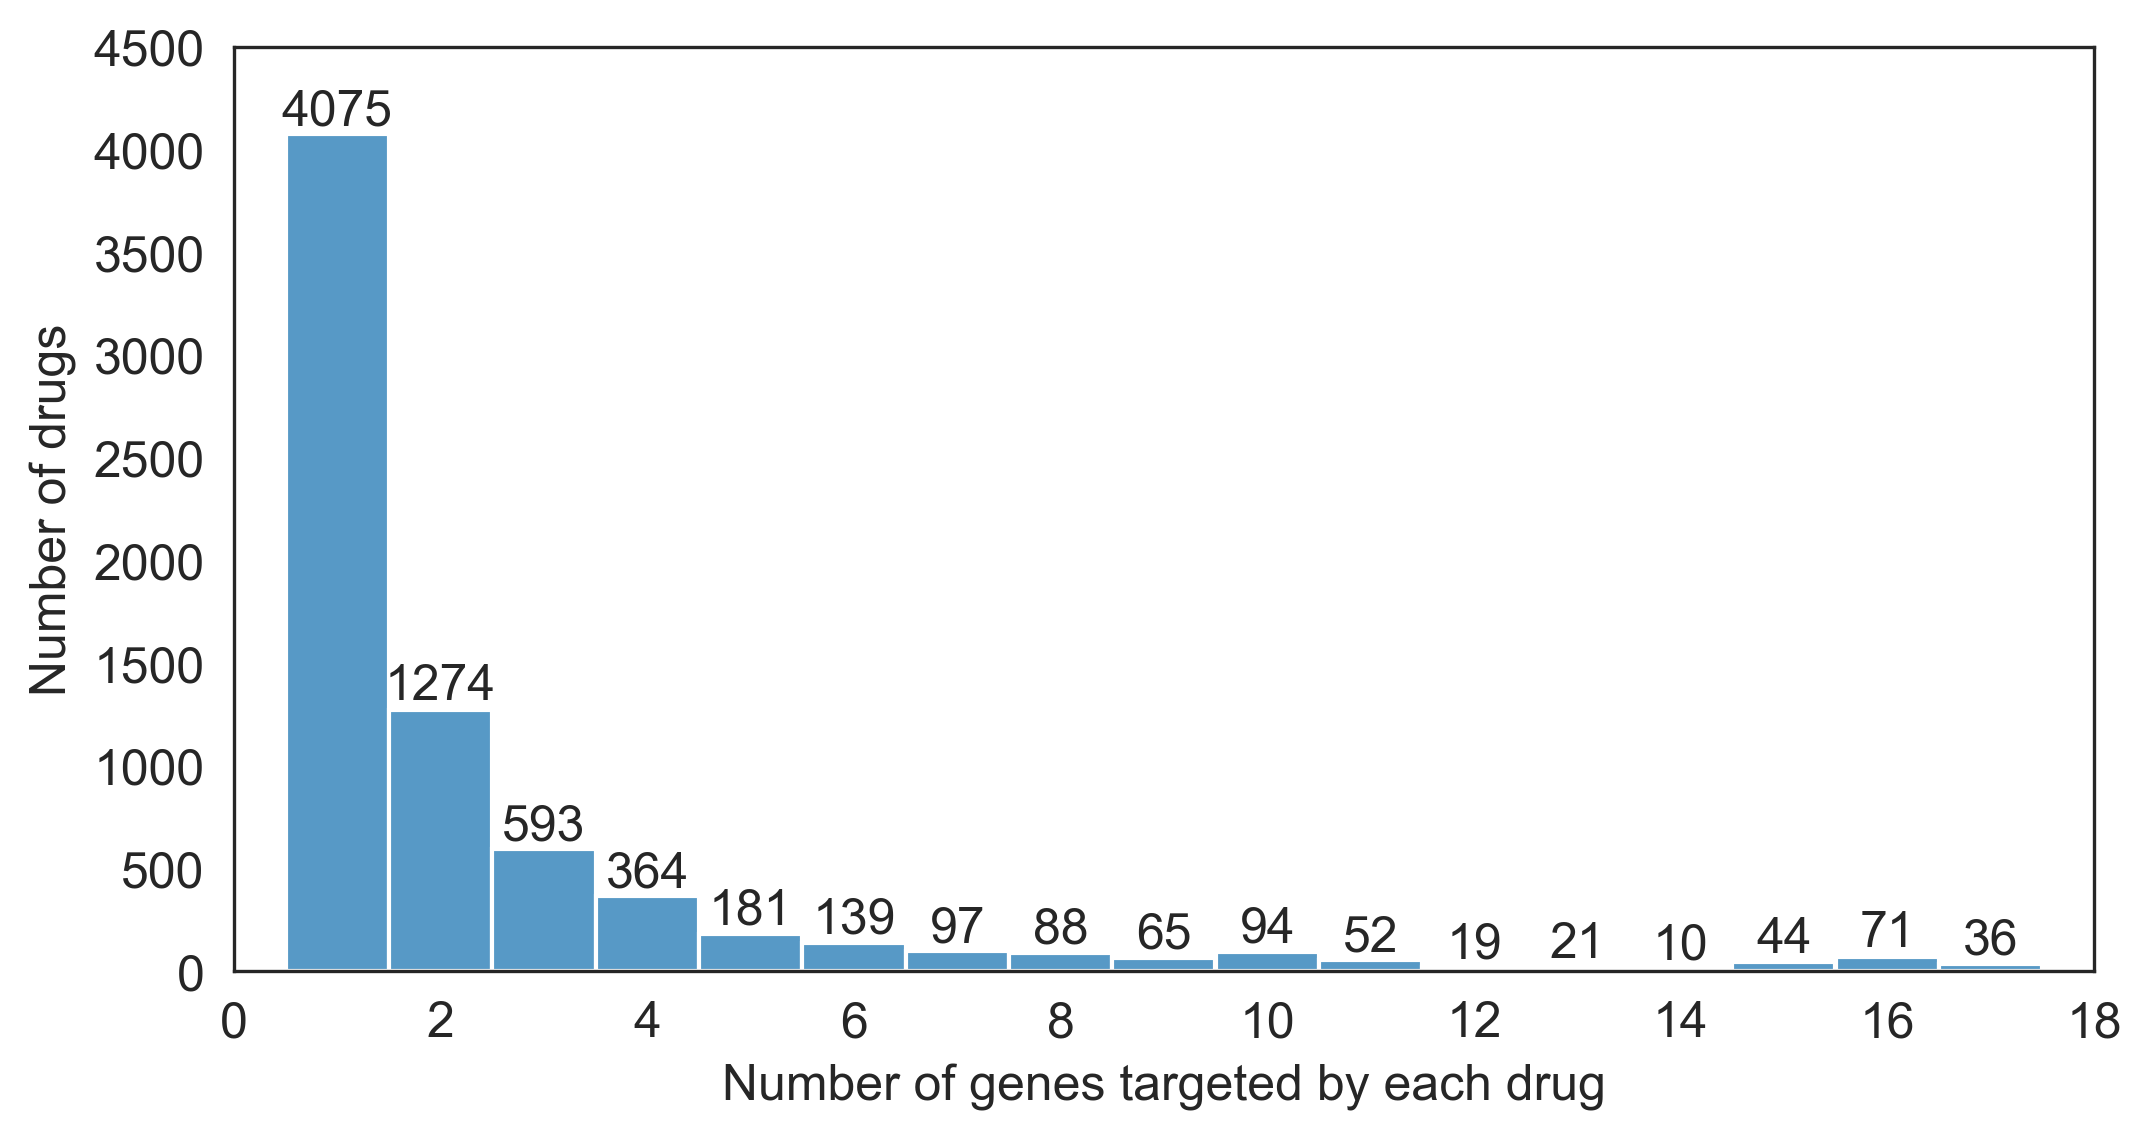

In [136]:
gpd = tg.groupby('ID')['Gene'].nunique().reset_index()
print(gpd['Gene'].median(), gpd['Gene'].quantile(0.75) - gpd['Gene'].quantile(0.25))

max=17
gpd = gpd.loc[gpd['Gene'] <= max]
print(len(gpd.loc[gpd['Gene'] == 1]))
print(len(gpd.loc[gpd['Gene'] <= 5]))

plt.figure(figsize=(8, 4), dpi=300)
sns.set_style('white')

ax = sns.histplot(gpd['Gene'], bins=range(0, max+1), discrete=True)
ax.bar_label(ax.containers[0])
plt.xlim([0, max+1])
plt.ylim([0,4500])
plt.ylabel('Number of drugs')
plt.xlabel('Number of genes targeted by each drug')
plt.show()


In [5]:
data

,Inhibitor,Other,Activator
gene,,,
A2M,True,True,False
AADAT,False,True,False
AAK1,True,False,False
AANAT,True,False,False
ABAT,True,False,False
...,...,...,...
XPO1,True,False,False
YARS1,True,False,False
YES1,True,False,False


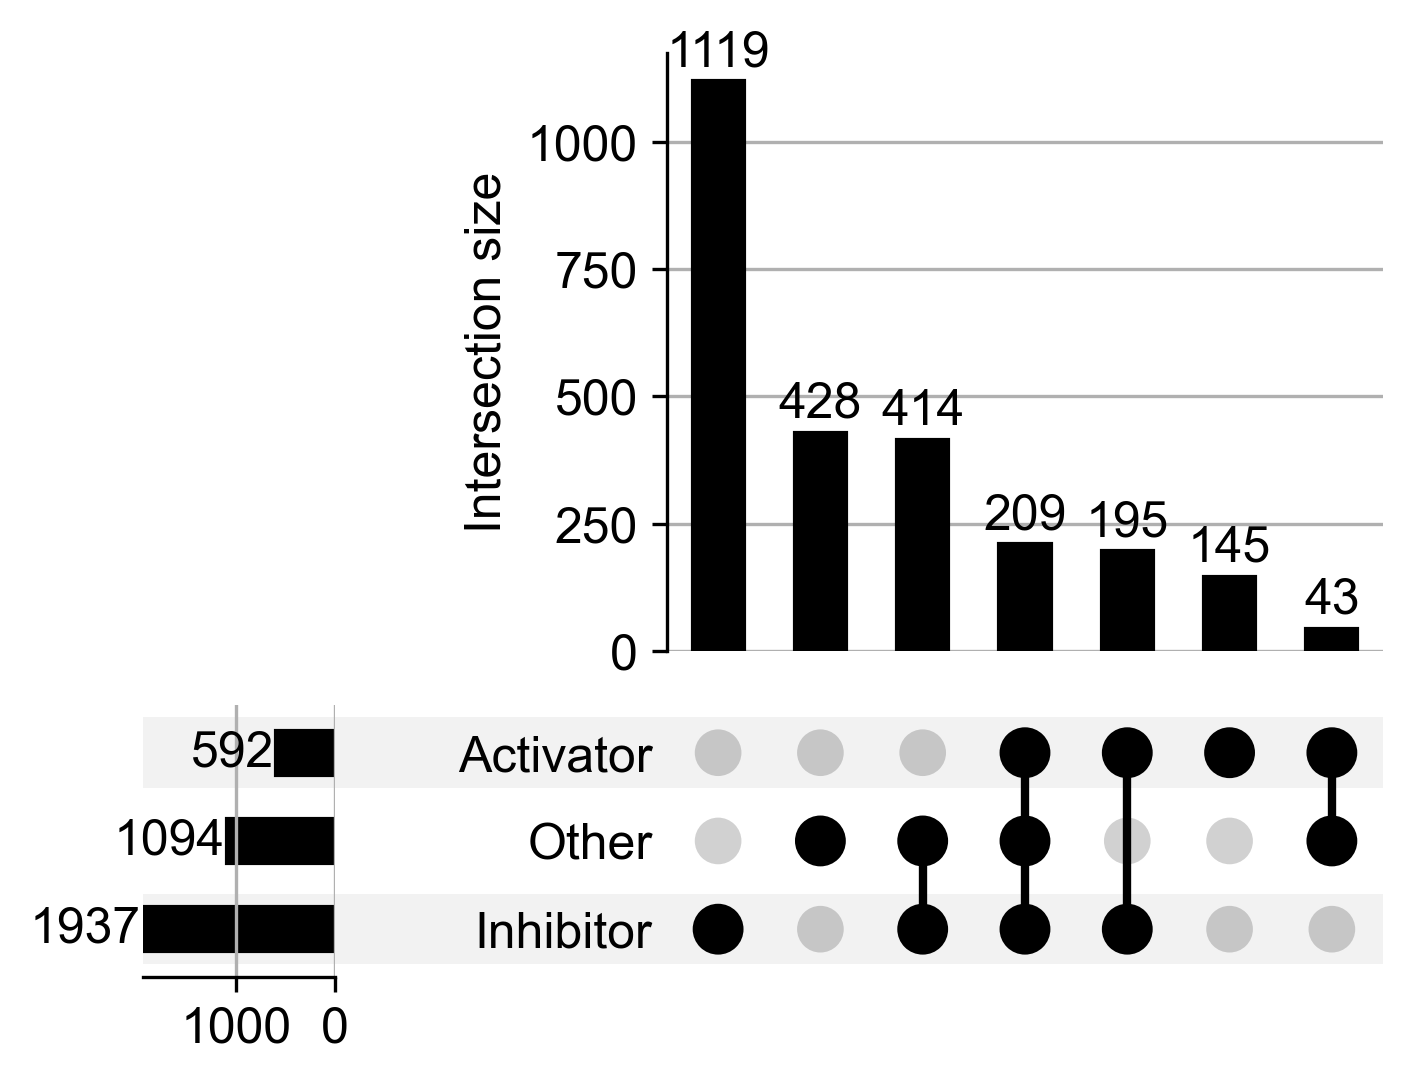

In [4]:
data = pd.read_pickle('./OT/Final/gene_direction.pkl')[['gene','neg','other','pos']].set_axis(['gene','Inhibitor','Other','Activator'],axis=1)
data.set_index('gene', inplace=True)
data = data.astype(bool)
upset_data = from_indicators(data=data, indicators=['Activator','Inhibitor','Other'])

fig = plt.figure(figsize=(8, 4), dpi=300)
upset = UpSet(upset_data, show_counts=True, sort_by='cardinality')
upset.plot(fig=fig)
plt.show()
